# Setup

## Importing libraries

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
pip install --upgrade setuptools pip

Requirement already up-to-date: setuptools in /usr/local/lib/python3.6/dist-packages (49.2.0)
Requirement already up-to-date: pip in /usr/local/lib/python3.6/dist-packages (20.1.1)


In [11]:
pip install nesmdb

  Using cached nesmdb-0.1.8.tar.gz (23 kB)
ERROR: Command errored out with exit status 1: python setup.py egg_info Check the logs for full command output.


In [5]:
import pickle

## Importing our dataset

Dataset: https://github.com/chrisdonahue/nesmdb

In [6]:
import requests 
url = "http://deepyeti.ucsd.edu/cdonahue/nesmdb/nesmdb24_blndsco.tar.gz"
  
r = requests.get(url)

with open("dataset.tar.gz",'wb') as f: 
    f.write(r.content) 

In [7]:
import tarfile
my_tar = tarfile.open('dataset.tar.gz')
my_tar.extractall('./dataset')
my_tar.close()

## Setting up global variables

# Preparation

## Utility functions

In [ ]:
def seprsco_to_arr(file,k=4,z=8,x=96,y=96):
  with open(file, 'rb') as f:
    rate, nsamps, seprsco = pickle.load(f)
  while(len(seprsco)<x*z): seprsco=np.concatenate((seprsco,seprsco),axis=0)

  arr = np.zeros([k,z,x,y],dtype='int8')
  for i in range(z*x):
    if(seprsco[i][0]!=0): arr[0,i//x,i%x,seprsco[i][0]-20]=1
    if(seprsco[i][1]!=0): arr[1,i//x,i%x,seprsco[i][1]-20]=1
    if(seprsco[i][2]!=0): arr[2,i//x,i%x,seprsco[i][2]-20]=1
    if(seprsco[i][3]!=0): arr[3,i//x,i%x,seprsco[i][3]]=1
  return arr

In [ ]:
def arr_to_seprsco(arr,k=4,z=8,x=96,y=96):
  seprsco=np.zeros([z*x,k])
  for i in range(z):
    for j in range(x):
      for b in range(y):
        if(arr[0][i][j][b]==1): seprsco[i*x+j,0]=b+20
        if(arr[1][i][j][b]==1): seprsco[i*x+j,1]=b+20
        if(arr[2][i][j][b]==1): seprsco[i*x+j,2]=b+20
        if(arr[3][i][j][b]==1): seprsco[i*x+j,3]=b
  return seprsco

In [ ]:
def fn_to_input(filename): return np.array([seprsco_to_arr(filename).reshape(96*96*8*4)])
def output_to_arr(out): return out.reshape(4,8,96,96)

## Preparing the dataset

# Creating the model

In [ ]:
inputs = keras.Input((96,96,16),batch_size=64)
inputs.shape

TensorShape([64, 96, 96, 16])

In [ ]:
x = layers.Reshape((16,-1))(inputs)
print(x.shape)
x = layers.TimeDistributed(layers.Dense(2000))(x)
print(x.shape)
x = layers.TimeDistributed(layers.Dense(200))(x)
print(x.shape)
x = layers.Flatten()(x)
print(x.shape)

(64, 16, 9216)
(64, 16, 2000)
(64, 16, 200)
(64, 3200)


In [ ]:
x = layers.Dense(1600)(x)
print(x.shape)
x = layers.Dense(120)(x)
print(x.shape)
x = layers.BatchNormalization(name='pre-encoder')(x)
print(x.shape)

(64, 1600)
(64, 120)
(64, 120)


In [ ]:
x = layers.Dense(1600)(x)
print(x.shape)
x = layers.BatchNormalization()(x)
print(x.shape)
x = layers.Activation(activation='relu')(x)
print(x.shape)
x = layers.Dense(16*200)(x)
print(x.shape)
x = layers.Reshape((16,200))(x)
print(x.shape)

(64, 1600)
(64, 1600)
(64, 1600)
(64, 3200)
(64, 16, 200)


In [ ]:
x = layers.BatchNormalization()(x)
print(x.shape)
x = layers.Activation(activation='relu')(x)
print(x.shape)
x = layers.Dense(2000)(x)
print(x.shape)
x = layers.BatchNormalization()(x)
print(x.shape)

(64, 16, 200)
(64, 16, 200)
(64, 16, 2000)
(64, 16, 2000)


In [ ]:
x = layers.Dense(96*96)(x)
print(x.shape)
x = layers.Reshape((96,96,16))(x)
print(x.shape)

(64, 16, 9216)
(64, 96, 96, 16)


In [ ]:
model = keras.Model(inputs,x)
model.compile(optimizer='adam',loss='binary_crossentropy') #TODO: try RMSprop

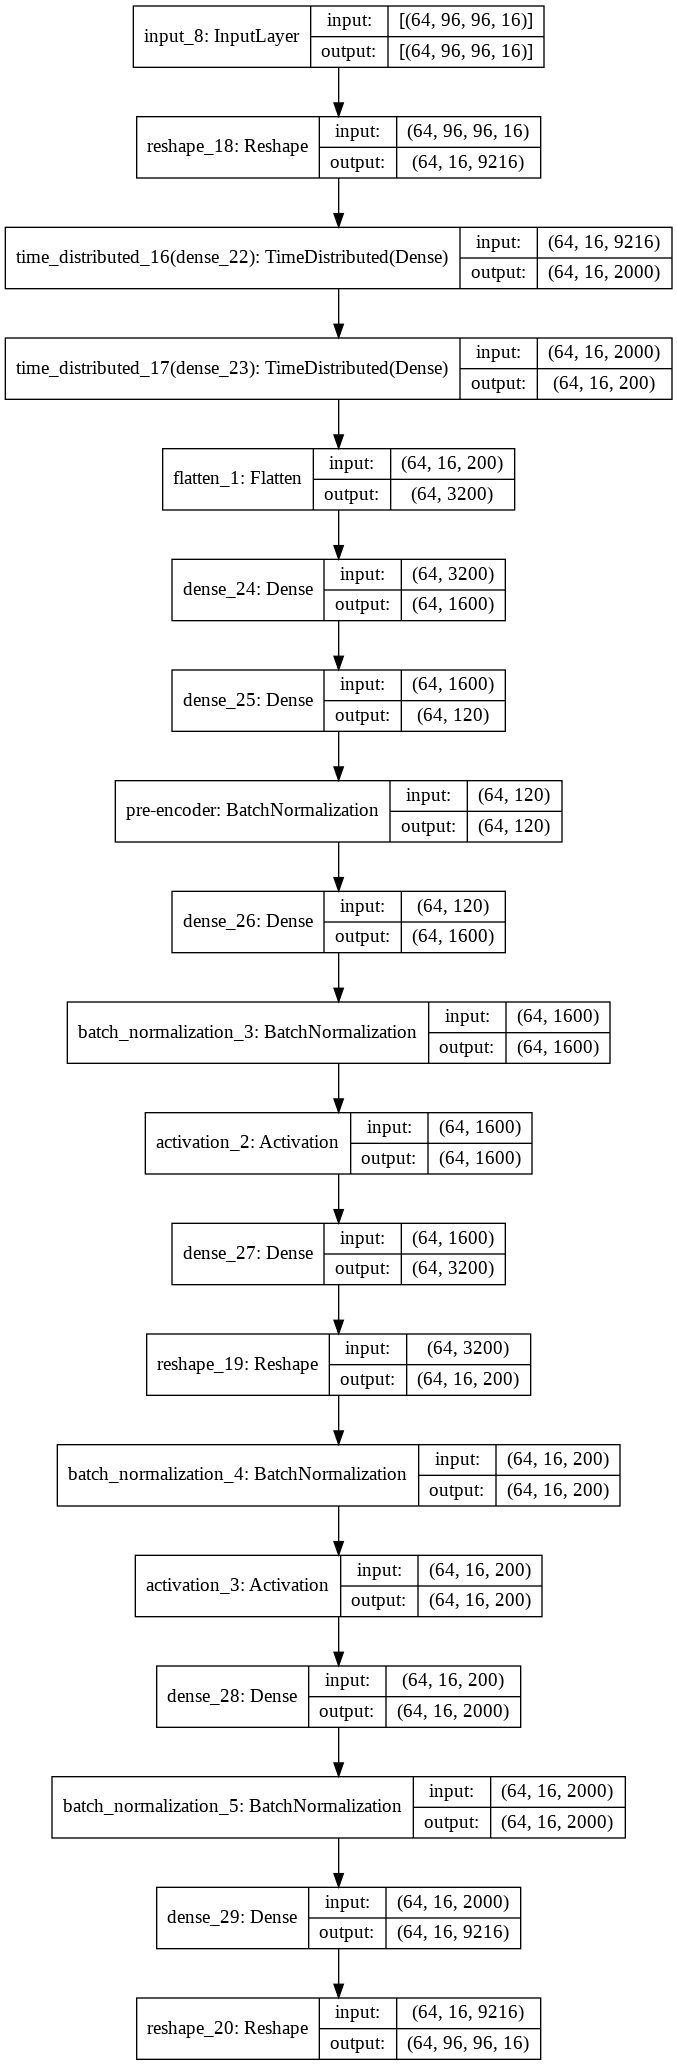

In [ ]:
keras.utils.plot_model(model, to_file='model.png', show_shapes=True)

# Training the model

In [ ]:
import glob;
from numpy import reshape

In [ ]:
x_train = np.array([seprsco_to_arr(filename).reshape(96*96*8*4) for filename in glob.iglob('dataset/nesmdb24_seprsco/train/*.seprsco.pkl')],dtype='int8')
x_test = np.array([np.reshape(seprsco_to_arr(filename),96*96*8*4) for filename in glob.iglob('dataset/nesmdb24_seprsco/test/*.seprsco.pkl')],dtype='int8')
x_valid = np.array([np.reshape(seprsco_to_arr(filename),96*96*8*4) for filename in glob.iglob('dataset/nesmdb24_seprsco/valid/*.seprsco.pkl')],dtype='int8')

In [ ]:
model.fit(x_train, x_train,
                epochs=100,
                batch_size=64,
                shuffle=True,
                validation_data=(x_test, x_test),)

In [ ]:
model.save('model 1.1-100e') # 100 epochs

In [ ]:
model = keras.models.load_model('model v1.0-100')

In [ ]:
path = 'dataset/nesmdb24_seprsco/valid/012_AlphaMission_01_02SYDsThemeArea.seprsco.pkl'

y = autoencoder.predict(fn_to_input(path))
y = np.round(y,4)
unique, counts = np.unique(y, return_counts=True)

In [ ]:
x = fn_to_input(path)
unique, counts = np.unique(x, return_counts=True)
dict(zip(unique, counts))

{0: 293620, 1: 1292}

In [ ]:
unique, counts = np.unique(y, return_counts=True)
dict(zip(unique, counts))

{0.0: 293278, 1.0: 1634}

In [ ]:
bar = np.percentile(y[0],99)+0.002
for i in range(len(y[0])):
  if(y[0][i]>=bar): y[0][i]=1
  else: y[0][i]=0

In [ ]:
xs = output_to_arr(y)
xs = arr_to_seprsco(xs)
xs

array([[ 0.,  0.,  0., 16.],
       [ 0.,  0., 48., 15.],
       [ 0.,  0., 48.,  0.],
       ...,
       [ 0.,  0., 48., 15.],
       [67.,  0., 48., 15.],
       [67.,  0., 48., 15.]])

In [8]:
path = 'dataset/nesmdb24_blndsco/valid/041_Caesar_sPalace_02_03CasinoFloorTheme2.blndsco.pkl'
from nesmdb.convert import blndsco_to_wav
with open(path, 'rb') as f:
  exprsco = pickle.load(f)
wav = blndsco_to_wav(exprsco)

ModuleNotFoundError: ignored

In [ ]:
wav = seprsco_to_wav((24,1466371,xs))

In [ ]:
from scipy.io.wavfile import write

write('test_wav_00.wav', 44100 , wav)

# Creating and exporting the generator